# xG data exploration

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_columns', None)

## Data preparation

In [2]:
shots = pd.read_feather('shots.ftr')

In [3]:
# COMP_ID = 11
# 
# season_ids = !ls statsbomb/data/matches/11
# season_ids = [x.split('.')[0] for x in matches]
# 
# match_ids = []
# for season_id in season_ids:
#     with open(f'statsbomb/data/matches/{COMP_ID}/{season_id}.json') as f:
#         data = json.load(f)
#     match_ids += [row['match_id'] for row in data]

In [4]:
# dfs = []
# for match_id in tqdm(match_ids):
#     with open(f'statsbomb/data/events/{match_id}.json') as f:
#         df = pd.json_normalize(json.loads(f.read()), sep='_')
#     dfs.append(df)
# df = pd.concat(dfs, sort=False)
# df.reset_index(drop=True, inplace=True)
# df.to_csv('df.csv')
# print('lol')

In [5]:
# shots = df.query('type_name == "Shot"')

In [6]:
pd.options.mode.chained_assignment = None
def parse_shots(shots):
    columns = ['x', 'y', 'head', 'phase', 'statsbombxg', 'outcome']
    
    shots['head'] = 1 * (shots.shot_body_part_name == 'Head')
    shots[['x', 'y']] = pd.DataFrame(shots.location.to_list(), index=shots.index)
    shots.x = (shots.x / 120 * 105).astype(int)
    shots.y = (shots.y / 80 * 68).astype(int)
    #pd.DataFrame(features.location.to_list(), index=features.index)
    
    shots['phase'] = shots.shot_type_name
    shots['statsbombxg'] = shots.shot_statsbomb_xg
    shots['outcome'] = 1 * (shots.shot_outcome_name == 'Goal')
    
    shots.drop(shots.columns.difference(columns), axis=1, inplace=True)
    shots = shots[shots.phase == 'Open Play']
    shots.reset_index(drop=True, inplace=True)
    
    return shots

In [7]:
shots = parse_shots(shots)

In [8]:
def distance_to_goal(origin):
    dest = np.array([105., 34.])
    return np.sqrt(np.sum((origin - dest) ** 2))

def goal_angle(origin):
    p0 = np.array((105., 34 - 7.32 / 2))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((105., 34 + 7.32 / 2))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

shots['distance_to_goal'] = shots.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
shots['goal_angle'] = shots.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)
shots['logdist'] = np.log(shots.distance_to_goal)
shots['logangle'] = np.log(shots.goal_angle)

In [9]:
#shots.hist(bins=50, figsize=(20, 12))

In [10]:
shots

,head,x,y,phase,statsbombxg,outcome,distance_to_goal,goal_angle,logdist,logangle
0,0,92,49,Open Play,0.026399,0,19.849433,0.245001,2.988175,-1.406494
1,0,96,33,Open Play,0.484256,1,9.055385,0.765143,2.203360,-0.267693
2,0,92,33,Open Play,0.334151,0,13.038405,0.546022,2.567899,-0.605095
3,0,100,41,Open Play,0.113160,0,8.602325,0.543294,2.152033,-0.610104
4,1,97,34,Open Play,0.159821,0,8.000000,0.858147,2.079442,-0.152980
...,...,...,...,...,...,...,...,...,...,...
10927,1,100,26,Open Play,0.063692,0,9.433981,0.450846,2.244318,-0.796630
10928,0,93,22,Open Play,0.050016,0,16.970563,0.309593,2.831480,-1.172498
10929,0,89,39,Open Play,0.034740,0,16.763055,0.412546,2.819177,-0.885409
10930,0,88,52,Open Play,0.010457,0,24.758837,0.204632,3.209182,-1.586543


## Fitting and evaluation

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score

train_set, test_set = train_test_split(shots, test_size=0.2, random_state=9)

In [12]:
len(train_set), len(test_set)

(8745, 2187)

In [13]:
#features = ['x', 'y']

#features = ['distance_to_goal', 'goal_angle']
features = ['x', 'y', 'distance_to_goal', 'goal_angle']

X_train = train_set[features]
y_train = train_set.outcome
X_test = test_set[features]
y_test = test_set.outcome

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

predictions = pipe.predict_proba(X_test)[:, 1]
accuracy = (predictions == y_test).mean()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.00


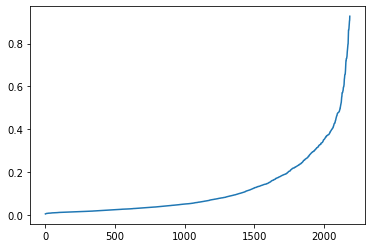

In [14]:

plt.plot(sorted(test_set.statsbombxg))

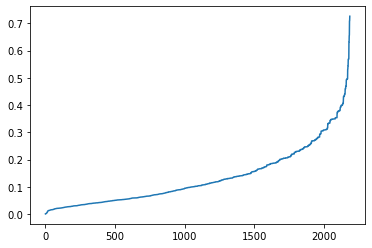

In [15]:

plt.plot(sorted(predictions))

In [16]:
from joblib import dump, load
dump(pipe, 'model.joblib') 

['model.joblib']

In [17]:
def eval_features(features, train_set, test_set):
    sbxg = test_set.statsbombxg
    sb_outcome = 1 * (sbxg > 0.5)
    
    X_train = train_set[features]
    y_train = train_set.outcome
    X_test = test_set[features]
    y_test = test_set.outcome
    
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)
    
    predictions = pipe.predict(X_test)
    accuracy = (predictions == y_test).mean()
    print(f'Accuracy: {accuracy:.2f}')
    sb_acc = (sb_outcome == y_test).mean()
    
    prob_predictions = pipe.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test, prob_predictions)
    print(f'Brier Score: {brier_score:.2f}')
    sb_brier = brier_score_loss(y_test, sbxg)
    
    auc_score = roc_auc_score(y_test, prob_predictions)
    print(f'AUC score: {auc_score:.2f}')
    
    auc_score = roc_auc_score(y_test, sbxg)
    print(f'Statsbomb accuracy: {sb_acc:.2f}')
    print(f'Statsbomb Brier Score: {sb_brier:.2f}')
    print(f'Statsbomb AUC score: {auc_score:.2f}')
    print()

In [18]:
features = ['x', 'y']
eval_features(features, train_set, test_set)
features = ['distance_to_goal', 'goal_angle']
eval_features(features, train_set, test_set)
features = ['logdist', 'logangle']
eval_features(features, train_set, test_set)
features = ['logdist', 'goal_angle']
eval_features(features, train_set, test_set)
features = ['x', 'y', 'distance_to_goal', 'goal_angle']
eval_features(features, train_set, test_set)

Accuracy: 0.87
Brier Score: 0.11
AUC score: 0.69
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

Accuracy: 0.87
Brier Score: 0.10
AUC score: 0.74
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

Accuracy: 0.87
Brier Score: 0.10
AUC score: 0.75
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

Accuracy: 0.87
Brier Score: 0.10
AUC score: 0.74
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

Accuracy: 0.87
Brier Score: 0.10
AUC score: 0.75
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

